#Using CRISP-DM methodology, predicting US Accidents Injury Severity



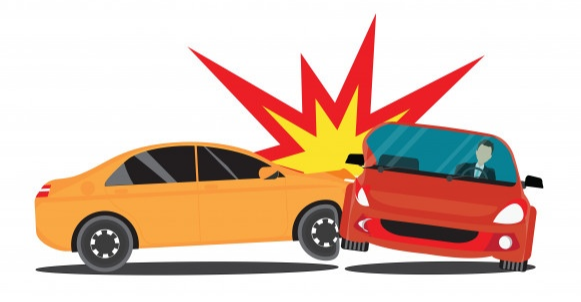

In [0]:
#My info here
__author__ = "Anup Kumar Chittimalla"
__email__ = "anup.chitts@gmail.com"

In [0]:
from google.colab import files
uploaded = files.upload()

Saving accident.sas7bdat to accident.sas7bdat
Saving distract.sas7bdat to distract.sas7bdat
Saving person.sas7bdat to person.sas7bdat
Saving vehicle.sas7bdat to vehicle.sas7bdat


In [0]:
#importing libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
import operator

#1. Business Understanding & Data Understanding

In [233]:
#Reading SAS files
dataframe = ["accident.sas7bdat","vehicle.sas7bdat","distract.sas7bdat","person.sas7bdat" ]
for data in dataframe:
  pd.read_sas(data)
print("Reading files completed")

Reading files completed


In [234]:
#Number of columns and rows of each dataframe and printing the first five rows of each dataframe
dataframes = [accident, vehicle, distract, person]
names = ["Accident","Vehicle","Distract","Person"]
i=0
for data in dataframes:
  print("-----------------------------------------------------------------------------------------")
  print("{}: {}".format(names[i],data.shape))
  print("-----------------------------------------------------------------------------------------")
  print(data.head(5))
  i += 1

-----------------------------------------------------------------------------------------
Accident: (54969, 51)
-----------------------------------------------------------------------------------------
        CASENUM  REGION   PSU     PJ  ...  NO_INJ_IM  ALCHL_IM  PSUSTRAT      WEIGHT
0  2.017000e+11     4.0  64.0  305.0  ...        1.0       2.0      23.0   29.270311
1  2.017000e+11     4.0  64.0  305.0  ...        3.0       2.0      23.0   62.100147
2  2.017000e+11     4.0  64.0  305.0  ...        0.0       2.0      23.0  181.168210
3  2.017000e+11     4.0  49.0  261.0  ...        1.0       2.0      21.0   27.870445
4  2.017000e+11     4.0  49.0  261.0  ...        0.0       2.0      21.0  236.352198

[5 rows x 51 columns]
-----------------------------------------------------------------------------------------
Vehicle: (97625, 87)
-----------------------------------------------------------------------------------------
        CASENUM  VEH_NO  REGION  ...  V_ALCH_IM  PSUSTRAT     WE

In [235]:
#dataframe info including column count and datatypes
i=0
for file in dataframes:
  print("--------------------------------------------")
  print("{}:".format(names[i]))
  print("--------------------------------------------")
  print(file.info(verbose=True))
  i += 1

--------------------------------------------
Accident:
--------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54969 entries, 0 to 54968
Data columns (total 51 columns):
CASENUM       54969 non-null float64
REGION        54969 non-null float64
PSU           54969 non-null float64
PJ            54969 non-null float64
PSU_VAR       54969 non-null float64
URBANICITY    54969 non-null float64
STRATUM       54969 non-null float64
VE_TOTAL      54969 non-null float64
VE_FORMS      54969 non-null float64
PVH_INVL      54969 non-null float64
PEDS          54969 non-null float64
PERMVIT       54969 non-null float64
PERNOTMVIT    54969 non-null float64
NUM_INJ       54969 non-null float64
MONTH         54969 non-null float64
YEAR          54969 non-null float64
DAY_WEEK      54969 non-null float64
HOUR          54969 non-null float64
MINUTE        54969 non-null float64
HARM_EV       54969 non-null float64
ALCOHOL       54969 non-null float64
MAX_SEV       

In [236]:
#Missing values in every dataframe
i=0
for file in dataframes:
  print("--------------------------------------------")
  print("{}:".format(names[i]))
  print("--------------------------------------------")
  print(file.isnull().sum()/len(file)*100)
  i += 1

--------------------------------------------
Accident:
--------------------------------------------
CASENUM       0.0
REGION        0.0
PSU           0.0
PJ            0.0
PSU_VAR       0.0
URBANICITY    0.0
STRATUM       0.0
VE_TOTAL      0.0
VE_FORMS      0.0
PVH_INVL      0.0
PEDS          0.0
PERMVIT       0.0
PERNOTMVIT    0.0
NUM_INJ       0.0
MONTH         0.0
YEAR          0.0
DAY_WEEK      0.0
HOUR          0.0
MINUTE        0.0
HARM_EV       0.0
ALCOHOL       0.0
MAX_SEV       0.0
MAN_COLL      0.0
RELJCT1       0.0
RELJCT2       0.0
TYP_INT       0.0
WRK_ZONE      0.0
REL_ROAD      0.0
LGT_COND      0.0
WEATHER1      0.0
WEATHER2      0.0
WEATHER       0.0
SCH_BUS       0.0
INT_HWY       0.0
CF1           0.0
CF2           0.0
CF3           0.0
WKDY_IM       0.0
HOUR_IM       0.0
MINUTE_IM     0.0
EVENT1_IM     0.0
MANCOL_IM     0.0
RELJCT1_IM    0.0
RELJCT2_IM    0.0
LGTCON_IM     0.0
WEATHR_IM     0.0
MAXSEV_IM     0.0
NO_INJ_IM     0.0
ALCHL_IM      0.0
PSUSTRAT      0.0


#2. Data Preparation


**1.   Data Consolidation**





*   Joining Accident with Vehicle using primary key "Accident case number" - (Right Join gives all the vehicle information involved in the accidents)
*   Joining the merged Accident and Vehicle with Person using "Accident case number and Vehicle number" - (Right Join gives all the Person details who are involved in the vehicle accidents)


*   The resultant "Injury" file can be used to explain the business question of predicting injury severity






In [237]:
#common columns in accident and vehicle
a = vehicle.columns.intersection(accident.columns)
print(a)

Index(['CASENUM', 'REGION', 'PSU', 'PJ', 'PSU_VAR', 'URBANICITY', 'STRATUM',
       'VE_FORMS', 'MONTH', 'HOUR', 'MINUTE', 'HARM_EV', 'MAN_COLL',
       'PSUSTRAT', 'WEIGHT'],
      dtype='object')


In [238]:
#common columns in distract and person
b = person.columns.intersection(distract.columns)
print(b)

Index(['CASENUM', 'VEH_NO', 'REGION', 'PSU', 'PJ', 'PSU_VAR', 'URBANICITY',
       'STRATUM', 'PSUSTRAT', 'WEIGHT'],
      dtype='object')


In [239]:
#Merging the data frames with the CASENUM (ACCIDENT with VEHICLE)
merge_acc_veh = pd.DataFrame()
merge_acc_veh = pd.merge(accident, vehicle, on =['CASENUM'], how='right')
merge_acc_veh.head(5)


,CASENUM,REGION_x,PSU_x,PJ_x,PSU_VAR_x,URBANICITY_x,STRATUM_x,VE_TOTAL,VE_FORMS_x,PVH_INVL,PEDS,PERMVIT,PERNOTMVIT,NUM_INJ,MONTH_x,YEAR,DAY_WEEK,HOUR_x,MINUTE_x,HARM_EV_x,ALCOHOL,MAX_SEV,MAN_COLL_x,RELJCT1,RELJCT2,TYP_INT,WRK_ZONE,REL_ROAD,LGT_COND,WEATHER1,WEATHER2,WEATHER,SCH_BUS,INT_HWY,CF1,CF2,CF3,WKDY_IM,HOUR_IM,MINUTE_IM,...,VEH_SC2,VEH_ALCH,MAX_VSEV,NUM_INJV,FIRE_EXP,DR_PRES,DR_ZIP,SPEEDREL,DR_SF1,DR_SF2,DR_SF3,DR_SF4,VTRAFWAY,VNUM_LAN,VSPD_LIM,VALIGN,VPROFILE,VSURCOND,VTRAFCON,VTCONT_F,P_CRASH1,P_CRASH2,P_CRASH3,PCRASH4,PCRASH5,ACC_TYPE,TRLR1VIN,TRLR2VIN,TRLR3VIN,HITRUN_IM,BDYTYP_IM,MDLYR_IM,IMPACT1_IM,VEVENT_IM,PCRASH1_IM,MXVSEV_IM,NUMINJ_IM,V_ALCH_IM,PSUSTRAT_y,WEIGHT_y
0,2.017000e+11,4.0,64.0,305.0,64.0,1.0,3.0,2.0,2.0,0.0,0.0,2.0,0.0,1.0,3.0,2017.0,4.0,17.0,45.0,12.0,2.0,2.0,6.0,8.0,2.0,6.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,17.0,45.0,...,0.0,2.0,0.0,0.0,0.0,1.0,95355.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,55.0,8.0,8.0,1.0,21.0,3.0,1.0,17.0,99.0,1.0,1.0,89.0,b'777777777777',b'777777777777',b'777777777777',0.0,9.0,1995.0,62.0,12.0,1.0,0.0,0.0,2.0,23.0,29.270311
1,2.017000e+11,4.0,64.0,305.0,64.0,1.0,3.0,2.0,2.0,0.0,0.0,2.0,0.0,1.0,3.0,2017.0,4.0,17.0,45.0,12.0,2.0,2.0,6.0,8.0,2.0,6.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,17.0,45.0,...,0.0,2.0,2.0,1.0,0.0,1.0,95351.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,55.0,8.0,8.0,1.0,21.0,3.0,1.0,66.0,99.0,1.0,1.0,88.0,b'777777777777',b'777777777777',b'777777777777',0.0,89.0,1986.0,12.0,12.0,1.0,2.0,1.0,2.0,23.0,29.270311
2,2.017000e+11,4.0,64.0,305.0,64.0,1.0,6.0,3.0,3.0,0.0,0.0,3.0,0.0,3.0,3.0,2017.0,5.0,7.0,40.0,12.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0,7.0,40.0,...,0.0,2.0,1.0,1.0,0.0,1.0,95692.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,65.0,1.0,1.0,1.0,0.0,0.0,2.0,53.0,16.0,1.0,1.0,98.0,b'777777777777',b'777777777777',b'777777777777',0.0,9.0,2016.0,6.0,12.0,2.0,1.0,1.0,2.0,23.0,62.100147
3,2.017000e+11,4.0,64.0,305.0,64.0,1.0,6.0,3.0,3.0,0.0,0.0,3.0,0.0,3.0,3.0,2017.0,5.0,7.0,40.0,12.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0,7.0,40.0,...,0.0,2.0,1.0,1.0,0.0,1.0,95209.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,65.0,1.0,1.0,1.0,0.0,0.0,2.0,53.0,16.0,1.0,1.0,29.0,b'777777777777',b'777777777777',b'777777777777',0.0,6.0,2015.0,6.0,12.0,2.0,1.0,1.0,2.0,23.0,62.100147
4,2.017000e+11,4.0,64.0,305.0,64.0,1.0,6.0,3.0,3.0,0.0,0.0,3.0,0.0,3.0,3.0,2017.0,5.0,7.0,40.0,12.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0,7.0,40.0,...,0.0,2.0,1.0,1.0,0.0,1.0,95212.0,4.0,0.0,0.0,0.0,0.0,3.0,4.0,65.0,1.0,1.0,1.0,0.0,0.0,1.0,52.0,16.0,1.0,1.0,28.0,b'777777777777',b'777777777777',b'777777777777',0.0,34.0,2016.0,12.0,12.0,1.0,1.0,1.0,2.0,23.0,62.100147


In [240]:
#Merging the data frames with the CASENUM, VEHNO (merge_acc_veh with PERSON)
Injury = pd.DataFrame()
Injury = pd.merge(merge_acc_veh, person, on = ['CASENUM', 'VEH_NO'], how='right')
Injury.head(5)

,CASENUM,REGION_x,PSU_x,PJ_x,PSU_VAR_x,URBANICITY_x,STRATUM_x,VE_TOTAL,VE_FORMS_x,PVH_INVL,PEDS,PERMVIT,PERNOTMVIT,NUM_INJ,MONTH_x,YEAR,DAY_WEEK,HOUR_x,MINUTE_x,HARM_EV_x,ALCOHOL,MAX_SEV,MAN_COLL_x,RELJCT1,RELJCT2,TYP_INT,WRK_ZONE,REL_ROAD,LGT_COND,WEATHER1,WEATHER2,WEATHER,SCH_BUS_x,INT_HWY,CF1,CF2,CF3,WKDY_IM,HOUR_IM,MINUTE_IM,...,TOW_VEH_y,SPEC_USE_y,EMER_USE_y,ROLLOVER_y,IMPACT1_y,FIRE_EXP_y,AGE,SEX,PER_TYP,INJ_SEV,SEAT_POS,REST_USE,REST_MIS,AIR_BAG,EJECTION,DRINKING,ALC_STATUS,ATST_TYP,ALC_RES,DRUGS,DSTATUS,DRUGTST1,DRUGTST2,DRUGTST3,DRUGRES1,DRUGRES2,DRUGRES3,HOSPITAL,P_SF1,P_SF2,P_SF3,LOCATION,SEX_IM,INJSEV_IM,EJECT_IM,PERALCH_IM,SEAT_IM,AGE_IM,PSUSTRAT,WEIGHT
0,2.017000e+11,4.0,64.0,305.0,64.0,1.0,3.0,2.0,2.0,0.0,0.0,2.0,0.0,1.0,3.0,2017.0,4.0,17.0,45.0,12.0,2.0,2.0,6.0,8.0,2.0,6.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,17.0,45.0,...,0.0,0.0,0.0,0.0,62.0,0.0,51.0,2.0,1.0,0.0,11.0,3.0,0.0,20.0,7.0,0.0,8.0,95.0,995.0,0.0,8.0,6.0,0.0,0.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,11.0,51.0,23.0,29.270311
1,2.017000e+11,4.0,64.0,305.0,64.0,1.0,3.0,2.0,2.0,0.0,0.0,2.0,0.0,1.0,3.0,2017.0,4.0,17.0,45.0,12.0,2.0,2.0,6.0,8.0,2.0,6.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,17.0,45.0,...,0.0,0.0,0.0,0.0,12.0,0.0,52.0,1.0,1.0,2.0,11.0,19.0,0.0,20.0,8.0,0.0,8.0,95.0,995.0,0.0,8.0,6.0,0.0,0.0,95.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,2.0,8.0,0.0,11.0,52.0,23.0,29.270311
2,2.017000e+11,4.0,64.0,305.0,64.0,1.0,6.0,3.0,3.0,0.0,0.0,3.0,0.0,3.0,3.0,2017.0,5.0,7.0,40.0,12.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0,7.0,40.0,...,0.0,0.0,0.0,0.0,6.0,0.0,54.0,2.0,1.0,1.0,11.0,3.0,0.0,20.0,0.0,0.0,8.0,95.0,995.0,0.0,8.0,6.0,0.0,0.0,95.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,11.0,54.0,23.0,62.100147
3,2.017000e+11,4.0,64.0,305.0,64.0,1.0,6.0,3.0,3.0,0.0,0.0,3.0,0.0,3.0,3.0,2017.0,5.0,7.0,40.0,12.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0,7.0,40.0,...,0.0,0.0,0.0,0.0,6.0,0.0,28.0,2.0,1.0,1.0,11.0,3.0,0.0,20.0,0.0,0.0,8.0,95.0,995.0,0.0,8.0,6.0,0.0,0.0,95.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,11.0,28.0,23.0,62.100147
4,2.017000e+11,4.0,64.0,305.0,64.0,1.0,6.0,3.0,3.0,0.0,0.0,3.0,0.0,3.0,3.0,2017.0,5.0,7.0,40.0,12.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0,7.0,40.0,...,0.0,0.0,0.0,0.0,12.0,0.0,29.0,1.0,1.0,1.0,11.0,3.0,0.0,9.0,0.0,0.0,8.0,95.0,995.0,0.0,8.0,6.0,0.0,0.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,11.0,29.0,23.0,62.100147


In [241]:
#Checking missing values in the Injury file
Injury.isnull().sum()/len(Injury)*100

CASENUM       0.000000
REGION_x      3.962912
PSU_x         3.962912
PJ_x          3.962912
PSU_VAR_x     3.962912
                ...   
PERALCH_IM    0.000000
SEAT_IM       0.000000
AGE_IM        0.000000
PSUSTRAT      0.000000
WEIGHT        0.000000
Length: 196, dtype: float64

**2. Data Filtering**

In [242]:
#Including the rows that has SEAT_POS 'front seat left side'
Injury = Injury.loc[Injury['SEAT_POS'] == 11]
Injury.shape

(97687, 196)

In [243]:
#Including the columns as per business knowledge and intuition and dropping the rest
Injury_final = pd.DataFrame(Injury, columns = ['CASENUM','URBANICITY', 'NUM_INJ','ALCOHOL','MAN_COLL', 
                                               'TYP_INT','WRK_ZONE','SPEEDREL','REL_ROAD','LGT_COND',
                                               'WEATHER','INT_HWY','MOD_YEAR_x','J_KNIFE','HAZ_INV',
                                               'ROLLOVER_y','DEFORMED','VSURCOND','AGE','SEX','INJ_SEV',
                                               'AIR_BAG','EJECTION','DRUGS'])
Injury_final.columns

Index(['CASENUM', 'URBANICITY', 'NUM_INJ', 'ALCOHOL', 'MAN_COLL', 'TYP_INT',
       'WRK_ZONE', 'SPEEDREL', 'REL_ROAD', 'LGT_COND', 'WEATHER', 'INT_HWY',
       'MOD_YEAR_x', 'J_KNIFE', 'HAZ_INV', 'ROLLOVER_y', 'DEFORMED',
       'VSURCOND', 'AGE', 'SEX', 'INJ_SEV', 'AIR_BAG', 'EJECTION', 'DRUGS'],
      dtype='object')

In [244]:
#Including the rows of dependent variable INJ_SEV from 1 to 4
Injury_final = Injury_final.loc[(Injury_final['INJ_SEV'] >= 1) & (Injury_final['INJ_SEV'] <= 4)]
Injury_final['INJ_SEV'].value_counts()

1.0    13613
2.0     7435
3.0     5095
4.0      710
Name: INJ_SEV, dtype: int64

**3. Feature Engineering**

In [245]:
#Fixed Width Binning for Age and creating new feature "Agegroup"
bins = [0,17,60,150]
labels = ["teen","adult","elderly"]
Injury_final['Agegroup'] = pd.cut(Injury.AGE, bins=bins, labels=labels)
Injury_final[['AGE','Agegroup']].head(5)

,AGE,Agegroup
1,52.0,adult
2,54.0,adult
3,28.0,adult
4,29.0,adult
10,46.0,adult


In [246]:
#Calculating vehicle age from current year minus vehicle model year
Injury_final['Veh_age'] = 2017 - Injury_final['MOD_YEAR_x']
Injury_final['Veh_age'].head(5)

1     31.0
2      1.0
3      2.0
4      1.0
10    14.0
Name: Veh_age, dtype: float64

In [247]:
#Dropping AGE and MOD_YEAR as we have created new variables
Injury_final = pd.DataFrame(Injury_final.drop(['MOD_YEAR_x','AGE'], axis=1))
Injury_final.columns

Index(['CASENUM', 'URBANICITY', 'NUM_INJ', 'ALCOHOL', 'MAN_COLL', 'TYP_INT',
       'WRK_ZONE', 'SPEEDREL', 'REL_ROAD', 'LGT_COND', 'WEATHER', 'INT_HWY',
       'J_KNIFE', 'HAZ_INV', 'ROLLOVER_y', 'DEFORMED', 'VSURCOND', 'SEX',
       'INJ_SEV', 'AIR_BAG', 'EJECTION', 'DRUGS', 'Agegroup', 'Veh_age'],
      dtype='object')

**4. Data Cleaning**

In [248]:
Injury_final.rename(columns={"CASENUM":"Casenum","URBANICITY":"Urban","TYP_INT":"Intersection_type",
                             "REL_ROAD":"Road_loc_of_crash","INT_HWY":"Interstate_highway",
                             "MAN_COLL":"Manner_of_collision","LGT_COND":"Light_condition",
                             "WEATHER":"Weather","ALCOHOL":"Alcohol_involved","HAZ_INV":"Hazard_involved",
                             "DEFORMED":"Veh_deform","SPEEDREL":"Driver_speed","VSURCOND":"Road_surfcond",
                             "NUM_INJ":"Num_of_injured","AIR_BAG":"Air_bag","ROLLOVER_y":"Rollover",
                             "WRK_ZONE":"Work_zone", "DRUGS":"Drugs_involved","SEX":"Sex",
                             "EJECTION":"Ejection","J_KNIFE":"J_knife","INJ_SEV":"Injury_sev",
                             "Agegroup":"Age_group"}, inplace=True) 
Injury_final.columns

Index(['Casenum', 'Urban', 'Num_of_injured', 'Alcohol_involved',
       'Manner_of_collision', 'Intersection_type', 'Work_zone', 'Driver_speed',
       'Road_loc_of_crash', 'Light_condition', 'Weather', 'Interstate_highway',
       'J_knife', 'Hazard_involved', 'Rollover', 'Veh_deform', 'Road_surfcond',
       'Sex', 'Injury_sev', 'Air_bag', 'Ejection', 'Drugs_involved',
       'Age_group', 'Veh_age'],
      dtype='object')

In [0]:
#After understanding metadata from business documents,assigning categorical names to the numbers all variables (classifying notapplicable/unknown values as "other")
Injury_cat = {"Injury_sev":              {1:"0", 2:"0", 3:"1", 4:"1"},
              "Sex":                     {2:"female" , 1:"male", 8:"other", 9:"other"},
              "Veh_age" :                {-7981:"0", -7982:"0", -1:"0"},
              "J_knife" :                {0:"not_artveh", 1:"no", 2:"yes_firstevent", 
                                          3:"yes_subseqevent"},
              "Urban" :                  {1:"urban", 2:"rural"},
              "Intersection_type" :      {1:"no",2:"yes",3:"yes",4:"yes",5:"yes",6:"yes",
                                          7:"yes",10:"yes",
                                          98:"other",99:"other"},
              "Work_zone" :              {0:"no",1:"yes",2:"yes",3:"yes",4:"yes"},
              "Interstate_highway" :     {0:"no",1:"yes",9:"unkown"},
              "Manner_of_collision" :    {0:"no",1:"fronttorear",2:"fronttofront",6:"angle",
                                          7:"sideswipe_samedir",8:"sideswipe_oppdir",9:"reartoside",
                                          10:"reartorear",11:"other",98:"other",99:"other"},
              "Light_condition" :        {1:"day",2:"dark",3:"dark",6:"dark",4:"dawn",5:"dusk",7:"other",
                                          8:"other",9:"other"},
              "Alcohol_involved" :       {1:"yes",2:"no",8:"other",9:"other"},
              "Hazard_involved" :        {1:"no",2:"yes"},
              "Veh_deform" :             {0:"no",2:"yes",4:"yes",6:"yes",8:"other",9:"other"},
              "Road_surfcond" :          {1:"dry",2:"wet",3:"snow",4:"ice",5:"sand",6:"water",7:"oil",
                                          0:"other",8:"other",10:"slush",11:"mud",98:"other",99:"other"},
              "Rollover" :               {0:"no",1:"yes",2:"yes",9:"yes"},
              "Air_bag" :                {1:"deployed",2:"deployed",3:"deployed",7:"deployed",
                                          8:"deployed",9:"deployed",20:"not deployed",28:"switched off",
                                          0:"other",97:"other",98:"other",99:"other"},
              "Drugs_involved" :         {0:"no",1:"yes",8:"other",9:"other"},
              "Ejection":                {0:"no",1:"yes",2:"yes",3:"yes",7:"other",8:"other",9:"other"},
              "Road_loc_of_crash":       {1:"onroadway",2:"shoulder",3:"median",4:"onroadside",
                                          5:"outsidetraffic",6:"offroadway",7:"inparking",8:"gore",
                                          10:"separator",11:"cont_leftturn_lane",98:"other",99:"other"},
              "Weather":                 {0:"nocond",1:"clear",2:"rain",3:"sleet",4:"snow",5:"fog",
                                          6:"crosswinds",7:"blowingsand",10:"cloudy",11:"blowingsnow",
                                          12:"freezingrain",8:"other",
                                          98:"other",99:"other"},
              "Driver_speed" :           {0:"no",2:"yes_racing",3:"yes_exceededSL",4:"yes_toofastforcond",
                                          5:"yes_noreason",8:"other",9:"other"}}       

In [250]:
#Replacing the dataframe with dictionary "Injury_cat"
Injury_final.replace(Injury_cat, inplace=True)
Injury_final.head(5)

,Casenum,Urban,Num_of_injured,Alcohol_involved,Manner_of_collision,Intersection_type,Work_zone,Driver_speed,Road_loc_of_crash,Light_condition,Weather,Interstate_highway,J_knife,Hazard_involved,Rollover,Veh_deform,Road_surfcond,Sex,Injury_sev,Air_bag,Ejection,Drugs_involved,Age_group,Veh_age
1,2.017000e+11,urban,1.0,no,angle,yes,no,no,onroadway,day,clear,no,not_artveh,no,no,yes,dry,male,0,not deployed,other,no,adult,31
2,2.017000e+11,urban,3.0,no,fronttorear,no,no,no,onroadway,day,clear,yes,not_artveh,no,no,yes,dry,female,0,not deployed,no,no,adult,1
3,2.017000e+11,urban,3.0,no,fronttorear,no,no,no,onroadway,day,clear,yes,not_artveh,no,no,yes,dry,female,0,not deployed,no,no,adult,2
4,2.017000e+11,urban,3.0,no,fronttorear,no,no,yes_toofastforcond,onroadway,day,clear,yes,not_artveh,no,no,yes,dry,male,0,deployed,no,no,adult,1
10,2.017000e+11,urban,1.0,no,fronttorear,no,no,no,onroadway,dark,cloudy,yes,not_artveh,no,no,yes,dry,male,1,not deployed,other,no,adult,14


In [251]:
#Missing values in Injury_final
Injury_final.isnull().sum()/len(Injury_final)*100

Casenum                0.000000
Urban                  0.000000
Num_of_injured         0.163855
Alcohol_involved       0.163855
Manner_of_collision    0.000000
Intersection_type      0.163855
Work_zone              0.163855
Driver_speed           0.163855
Road_loc_of_crash      0.163855
Light_condition        0.163855
Weather                0.163855
Interstate_highway     0.163855
J_knife                0.163855
Hazard_involved        0.163855
Rollover               0.000000
Veh_deform             0.163855
Road_surfcond          0.163855
Sex                    0.000000
Injury_sev             0.000000
Air_bag                0.000000
Ejection               0.000000
Drugs_involved         0.000000
Age_group              1.649723
Veh_age                0.163855
dtype: float64

In [258]:
#Dropping null values as there are very less percentage of null values
Injury_final = Injury_final.dropna()
Injury_final.isnull().sum()/len(Injury_final)*100

Casenum                0.0
Urban                  0.0
Num_of_injured         0.0
Alcohol_involved       0.0
Manner_of_collision    0.0
Intersection_type      0.0
Work_zone              0.0
Driver_speed           0.0
Road_loc_of_crash      0.0
Light_condition        0.0
Weather                0.0
Interstate_highway     0.0
J_knife                0.0
Hazard_involved        0.0
Rollover               0.0
Veh_deform             0.0
Road_surfcond          0.0
Sex                    0.0
Injury_sev             0.0
Air_bag                0.0
Ejection               0.0
Drugs_involved         0.0
Age_group              0.0
Veh_age                0.0
dtype: float64

In [259]:
injury_cats = pd.DataFrame(Injury_final.drop(['Injury_sev','Casenum','Veh_age','Num_of_injured'], axis=1))
injury_cats.head(5)

,Urban,Alcohol_involved,Manner_of_collision,Intersection_type,Work_zone,Driver_speed,Road_loc_of_crash,Light_condition,Weather,Interstate_highway,J_knife,Hazard_involved,Rollover,Veh_deform,Road_surfcond,Sex,Air_bag,Ejection,Drugs_involved,Age_group
1,urban,no,angle,yes,no,no,onroadway,day,clear,no,not_artveh,no,no,yes,dry,male,not deployed,other,no,adult
2,urban,no,fronttorear,no,no,no,onroadway,day,clear,yes,not_artveh,no,no,yes,dry,female,not deployed,no,no,adult
3,urban,no,fronttorear,no,no,no,onroadway,day,clear,yes,not_artveh,no,no,yes,dry,female,not deployed,no,no,adult
4,urban,no,fronttorear,no,no,yes_toofastforcond,onroadway,day,clear,yes,not_artveh,no,no,yes,dry,male,deployed,no,no,adult
10,urban,no,fronttorear,no,no,no,onroadway,dark,cloudy,yes,not_artveh,no,no,yes,dry,male,not deployed,other,no,adult


In [263]:
#Label encoding
for col in list(injury_cats.columns):
    le = preprocessing.LabelEncoder()
    injury_cats[col] = le.fit_transform(injury_cats[col].astype(str))
injury_cats.head(5)

,Urban,Alcohol_involved,Manner_of_collision,Intersection_type,Work_zone,Driver_speed,Road_loc_of_crash,Light_condition,Weather,Interstate_highway,J_knife,Hazard_involved,Rollover,Veh_deform,Road_surfcond,Sex,Air_bag,Ejection,Drugs_involved,Age_group
1,1,0,0,2,0,0,8,2,4,0,1,0,0,2,0,1,1,1,0,0
2,1,0,2,0,0,0,8,2,4,1,1,0,0,2,0,0,1,0,0,0
3,1,0,2,0,0,0,8,2,4,1,1,0,0,2,0,0,1,0,0,0
4,1,0,2,0,0,5,8,2,4,1,1,0,0,2,0,1,0,0,0,0
10,1,0,2,0,0,0,8,0,5,1,1,0,0,2,0,1,1,1,0,0


In [262]:
#Converting all the categorical variables to category datatype and dropping null values
injury_cats = injury_cats.astype('category')
injury_cats.dtypes

Urban                  category
Alcohol_involved       category
Manner_of_collision    category
Intersection_type      category
Work_zone              category
Driver_speed           category
Road_loc_of_crash      category
Light_condition        category
Weather                category
Interstate_highway     category
J_knife                category
Hazard_involved        category
Rollover               category
Veh_deform             category
Road_surfcond          category
Sex                    category
Air_bag                category
Ejection               category
Drugs_involved         category
Age_group              category
dtype: object

In [264]:
#dataframe with only the numerical variables
injury_nums = pd.DataFrame(Injury_final, columns = ['Injury_sev','Casenum','Veh_age','Num_of_injured'])
injury_nums.head(5)

,Injury_sev,Casenum,Veh_age,Num_of_injured
1,0,2.017000e+11,31,1.0
2,0,2.017000e+11,1,3.0
3,0,2.017000e+11,2,3.0
4,0,2.017000e+11,1,3.0
10,1,2.017000e+11,14,1.0


In [266]:
injury_nums.dtypes

Injury_sev         object
Casenum           float64
Veh_age            object
Num_of_injured    float64
dtype: object

In [267]:
#changing data types of Injury_sev and Veh_age
injury_nums["Veh_age"] = injury_nums["Veh_age"].astype(float)
injury_nums.dtypes

Injury_sev         object
Casenum           float64
Veh_age           float64
Num_of_injured    float64
dtype: object

In [268]:
#concatenating injury_num and injury_no_num
injury_clean = pd.concat([injury_cats, injury_nums], axis=1)
injury_clean.shape

(26367, 24)

**5. Descriptive Statistics**

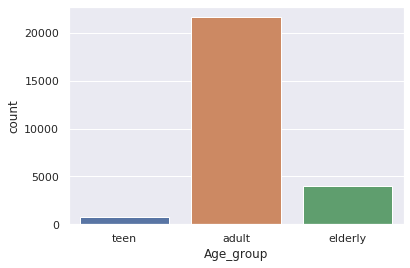

-------------------------------------------------------------


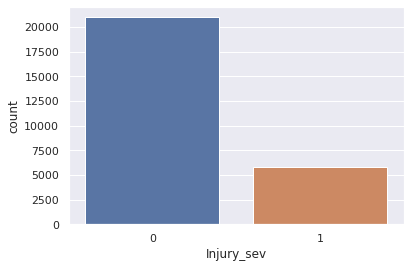

-------------------------------------------------------------


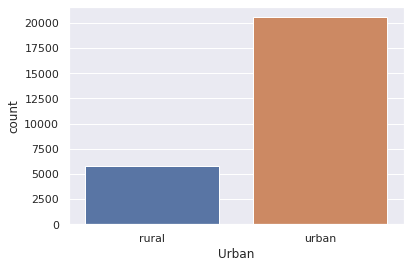

-------------------------------------------------------------


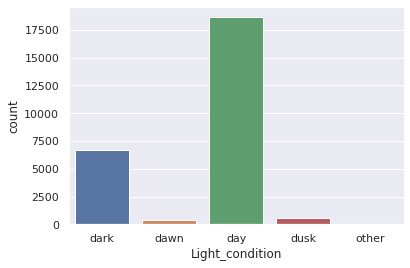

-------------------------------------------------------------


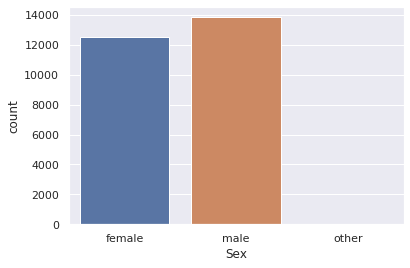

-------------------------------------------------------------


In [116]:
var = ["Age_group","Injury_sev","Urban","Light_condition","Sex"]
for v in var:
    sns.set(style="darkgrid")
    sns.countplot(x=v, data=injury_clean)
    plt.show()
    print("-------------------------------------------------------------")

Dependent variable (Injury Severity) is heavyily imbalanced; minority class is very low

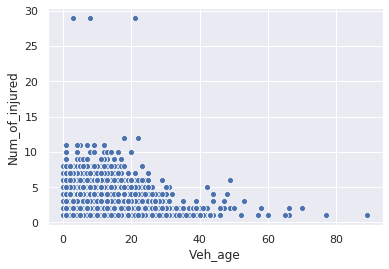

In [117]:
#Relationship between vehicle age and number of injured
ax = sns.scatterplot(x="Veh_age", y="Num_of_injured",data=injury_clean) 

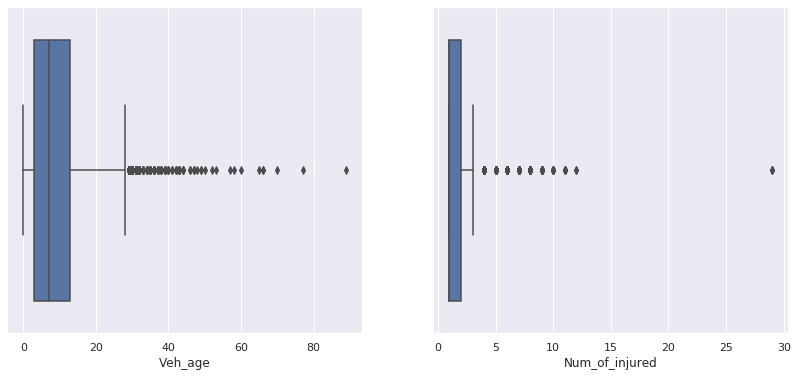

In [120]:
#Boxplots of Vehicle age and Num_of_injured
plt.figure(figsize = (14,6))
plt.subplot(1,2,1)
bx = sns.boxplot(x="Veh_age", data=injury_clean) 
plt.subplot(1,2,2)
cx = sns.boxplot(x="Num_of_injured", data=injury_clean) 

In [138]:
#potential outliers
v = ['Veh_age','Num_of_injured']
for v in var:
  stat = injury_clean[v].describe()
  IQR = stat['75%'] - stat['25%']
  upper = stat['75%'] + 1.5 * IQR
  lower = stat['25%'] - 1.5 * IQR
  print("stat:\t {}".format(stat))
  print("-----------------------------------------------------")
  print("IQR:\t {}".format(IQR))
  print("upper:\t {}".format(upper))
  print("lower:\t {}".format(lower))
  print('The upper and lower bounds for suspected outliers are {} and {}.'.format(upper, lower))
    

stat:	 count    26809.000000
mean         8.403932
std          6.813752
min          0.000000
25%          3.000000
50%          7.000000
75%         13.000000
max         89.000000
Name: Veh_age, dtype: float64
-----------------------------------------------------
IQR:	 10.0
upper:	 28.0
lower:	 -12.0
The upper and lower bounds for suspected outliers are 28.0 and -12.0.
stat:	 count    26809.000000
mean         1.835690
std          1.196384
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         29.000000
Name: Num_of_injured, dtype: float64
-----------------------------------------------------
IQR:	 1.0
upper:	 3.5
lower:	 -0.5
The upper and lower bounds for suspected outliers are 3.5 and -0.5.


In [270]:
Injury_nocase.round().head(5)

,Urban,Alcohol_involved,Manner_of_collision,Intersection_type,Work_zone,Driver_speed,Road_loc_of_crash,Light_condition,Weather,Interstate_highway,J_knife,Hazard_involved,Rollover,Veh_deform,Road_surfcond,Sex,Air_bag,Ejection,Drugs_involved,Age_group,Injury_sev,Veh_age,Num_of_injured
1,1,0,0,2,0,0,7,2,3,0,1,0,0,2,0,1,1,1,0,0,0,31.0,1.0
2,1,0,2,0,0,0,7,2,3,1,1,0,0,2,0,0,1,0,0,0,0,1.0,3.0
3,1,0,2,0,0,0,7,2,3,1,1,0,0,2,0,0,1,0,0,0,0,2.0,3.0
4,1,0,2,0,0,5,7,2,3,1,1,0,0,2,0,1,0,0,0,0,0,1.0,3.0
10,1,0,2,0,0,0,7,0,4,1,1,0,0,2,0,1,1,1,0,0,1,14.0,1.0


In [271]:
#Dropping casenum as it is not needed for Tree based models
Injury_nocase = pd.DataFrame(injury_clean.drop(columns=['Casenum']))
Injury_nocase.columns

Index(['Urban', 'Alcohol_involved', 'Manner_of_collision', 'Intersection_type',
       'Work_zone', 'Driver_speed', 'Road_loc_of_crash', 'Light_condition',
       'Weather', 'Interstate_highway', 'J_knife', 'Hazard_involved',
       'Rollover', 'Veh_deform', 'Road_surfcond', 'Sex', 'Air_bag', 'Ejection',
       'Drugs_involved', 'Age_group', 'Injury_sev', 'Veh_age',
       'Num_of_injured'],
      dtype='object')

#3. Modeling

In [0]:
#Splitting the dependent and independent variables
X = pd.DataFrame(Injury_nocase.drop(columns=['Injury_sev']))
Y = pd.DataFrame(Injury_nocase['Injury_sev'], index=None)

In [0]:
#Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, 
                                                    stratify=Y, random_state = 77)

In [0]:
#Converting dataframe to ndarray to run SMOTE analysis
X_train = X_train.values
y_train = y_train.values

In [0]:
################### CREATING CLASS FOR MODEL RESULTS ######################

class model_results:
    
    def __init__(self,accuracy,precision,recall,f1,models,auc):
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall
        self.f1 = f1
        self.models = models
        self.auc = auc
        
    def print_res(self):
        print("_______________________________________________")
        print("\t" + format(self.models))
        print("_______________________________________________")
        print("accuracy:\t {}".format(self.accuracy))
        print("precision:\t {}".format(self.precision))
        print("recall:\t\t {}".format(self.recall))
        print("f1:\t\t {}".format(self.f1))
        print("AUC:\t\t {}".format(self.auc))

#Creating function for best metric       
def optimum_model(results_list, metric):
        accuracies = {}
        precisions = {}
        recalls = {}
        f1s = {}
        aucs = {}
        for result in results_list:
            accuracies[result] = result.accuracy
            precisions[result] = result.precision
            recalls[result] = result.recall
            f1s[result] = result.f1
            aucs[result] = result.auc
        if metric == 'accuracy':
            return max(accuracies.items(), key=operator.itemgetter(1))[0]
        elif metric == 'precision':
            return max(precisions.items(), key=operator.itemgetter(1))[0]
        elif metric == 'recall':
            return max(recalls.items(), key=operator.itemgetter(1))[0]
        elif metric == 'f1':
            return max(f1s.items(), key=operator.itemgetter(1))[0]
        elif metric == 'auc':
            return max(aucs.items(), key=operator.itemgetter(1))[0]                     
            
#Print results function
def print_results(headline, true_value, pred):
    accuracy = accuracy_score(true_value, pred)
    precision = precision_score(true_value, pred, average="binary", pos_label="0")
    recall = recall_score(true_value, pred, average="binary", pos_label="0")
    f1 = f1_score(true_value, pred, average="binary", pos_label="0")
    auc = roc_auc_score(true_value, pred)
    result = model_results(accuracy,precision,recall,f1,auc,headline)
    print("______________________________________________________________________________________")
    print("\t" + headline)
    print("______________________________________________________________________________________")
    print("accuracy:\t {}".format(accuracy))
    print("precision:\t {}".format(precision))
    print("recall:\t\t {}".format(recall))
    print("f1:\t\t {}".format(f1))
    print("AUC:\t\t {}".format(auc))
    print("______________________________________________________________________________________")
    print(classification_report(y_test, samp_prediction))
    print(classification_report_imbalanced(y_test, samp_prediction))
    return result

In [278]:
#Creating model objects
rfc = RandomForestClassifier(random_state = 77)
dtc = DecisionTreeClassifier(random_state = 77)
knr = KNeighborsClassifier(n_neighbors=3)

models = [rfc, dtc, knr]

#Building pipeline model
for mod in models:
    f = type(mod).__name__
    pipeline = make_pipeline(mod)
    model = pipeline.fit(X_train, y_train)
    prediction = model.predict(X_test)
    print()
    print("-----------------------------------------------------------------------------------------")
    print(f+" "+'pipeline score {}'.format(pipeline.score(X_test, y_test)))
    print("-----------------------------------------------------------------------------------------")
    print(classification_report(y_test, prediction))
    print("-----------------------------------------------------------------------------------------")
    print(classification_report_imbalanced(y_test, prediction))


-----------------------------------------------------------------------------------------
RandomForestClassifier pipeline score 0.7737327771457464
-----------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      6195
           1       0.45      0.22      0.29      1716

    accuracy                           0.77      7911
   macro avg       0.63      0.57      0.58      7911
weighted avg       0.73      0.77      0.74      7911

-----------------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

          0       0.81      0.93      0.22      0.87      0.45      0.21      6195
          1       0.45      0.22      0.93      0.29      0.45      0.19      1716

avg / total       0.73      0.77      0.37      0.74      0.45      0.21      7911


---------

In [281]:
#Using SMOTE and Nearmiss with different models
smt = SMOTE(random_state = 77)
nms = NearMiss()
sampler = [smt, nms]
results = []
for classifier in models:
    for samp in sampler:
        s = type(samp).__name__
        c = type(classifier).__name__
        samp_pipeline = make_pipeline_imb(samp, classifier)
        samp_model = samp_pipeline.fit(X_train, y_train)
        samp_prediction = samp_model.predict(X_test)
        p = print_results(s+" "+c, y_test, samp_prediction)
        results.append(p)

______________________________________________________________________________________
	SMOTE RandomForestClassifier
______________________________________________________________________________________
accuracy:	 0.7627354316774112
precision:	 0.8132617527568196
recall:		 0.9047619047619048
f1:		 0.8565752273248262
AUC:		 0.5773809523809523
______________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.81      0.90      0.86      6195
           1       0.42      0.25      0.31      1716

    accuracy                           0.76      7911
   macro avg       0.62      0.58      0.59      7911
weighted avg       0.73      0.76      0.74      7911

                   pre       rec       spe        f1       geo       iba       sup

          0       0.81      0.90      0.25      0.86      0.48      0.24      6195
          1       0.42      0.25      0.90      0.31      0.48      0.21  

#4. Evaluation

In [282]:
######################### MODEL EVALUATION ################################  
### As SMOTE() gave good results than Nearmiss(), evaluating all models with 
### 4-fold cross validation ###    

kf = KFold(n_splits=4, random_state=77)
accuracy = []
precision = []
recall = []
f1 = []
auc = []
for mods in models:
    for train, test in kf.split(X_train, y_train):
        b = type(mods).__name__
        pipeline = make_pipeline_imb(SMOTE(random_state = 77), mods)
        model = pipeline.fit(X_train[train], y_train[train])
        prediction = model.predict(X_train[test])
        accuracy.append(pipeline.score(X_train[test], y_train[test]))
        precision.append(precision_score(y_train[test], prediction,average="binary",pos_label="0"))
        recall.append(recall_score(y_train[test], prediction,average="binary",pos_label="0"))
        f1.append(f1_score(y_train[test], prediction,average="binary",pos_label="0"))
        auc.append(roc_auc_score(y_train[test], prediction))
    print("_______________________________________________")
    print(b)
    print("_______________________________________________")
    print("Mean of scores for 4-fold:")
    print("accuracy: {}".format(np.mean(accuracy)))
    print("precision: {}".format(np.mean(precision)))
    print("recall: {}".format(np.mean(recall)))
    print("f1: {}".format(np.mean(f1)))        
    print("AUC: {}".format(np.mean(auc))) 

_______________________________________________
RandomForestClassifier
_______________________________________________
Mean of scores for 4-fold:
accuracy: 0.7640333766796706
precision: 0.8115973183013381
recall: 0.9099232918479478
f1: 0.8579015752894077
AUC: 0.5740162905697398
_______________________________________________
DecisionTreeClassifier
_______________________________________________
Mean of scores for 4-fold:
accuracy: 0.7357228001733853
precision: 0.8130426584613392
recall: 0.8605906789747515
f1: 0.8353418725953314
AUC: 0.5731597784553375
_______________________________________________
KNeighborsClassifier
_______________________________________________
Mean of scores for 4-fold:
accuracy: 0.703059528969802
precision: 0.8184755087929431
recall: 0.7992672024623997
f1: 0.8052939613669258
AUC: 0.5777801809410036


In [285]:
#printing the optimum model for each metric
metrics = ["accuracy","precision","recall","f1","auc"]
for metric in metrics:
    print("\nMetric:\t" + metric)
    om_acc = optimum_model(results, metric)
    om_acc.print_res()  


Metric:	accuracy
_______________________________________________
	0.5773809523809523
_______________________________________________
accuracy:	 0.7627354316774112
precision:	 0.8132617527568196
recall:		 0.9047619047619048
f1:		 0.8565752273248262
AUC:		 SMOTE RandomForestClassifier

Metric:	precision
_______________________________________________
	0.5871092184651506
_______________________________________________
accuracy:	 0.48729616989002655
precision:	 0.862419518807184
recall:		 0.41081517352703795
f1:		 0.5565274436912312
AUC:		 NearMiss RandomForestClassifier

Metric:	recall
_______________________________________________
	0.5773809523809523
_______________________________________________
accuracy:	 0.7627354316774112
precision:	 0.8132617527568196
recall:		 0.9047619047619048
f1:		 0.8565752273248262
AUC:		 SMOTE RandomForestClassifier

Metric:	f1
_______________________________________________
	0.5773809523809523
_______________________________________________
accuracy:	 0.7

In [294]:
############################### FEATURE IMPORTANCE ################################
X = pd.DataFrame(X)  
feature_importances = rfc.feature_importances_
attributes = X.columns
sorted(zip(feature_importances, attributes), reverse=True)


[(0.2609043105487865, 'Veh_age'),
 (0.08646793231977343, 'Num_of_injured'),
 (0.06536928161325951, 'Weather'),
 (0.06465912873233108, 'Manner_of_collision'),
 (0.05049373115126037, 'Light_condition'),
 (0.04333924606632484, 'Air_bag'),
 (0.04199603912324326, 'Road_loc_of_crash'),
 (0.041569482733518445, 'Ejection'),
 (0.041534364174877804, 'Age_group'),
 (0.03933489024865086, 'Sex'),
 (0.03858324065209073, 'Intersection_type'),
 (0.03681748402533088, 'Alcohol_involved'),
 (0.03236502012786284, 'Urban'),
 (0.03098517843268785, 'Driver_speed'),
 (0.03048248295164128, 'Road_surfcond'),
 (0.024730992847435934, 'Drugs_involved'),
 (0.0226889850044863, 'Veh_deform'),
 (0.019925479922305582, 'Rollover'),
 (0.018294217503107755, 'Interstate_highway'),
 (0.006145469275038829, 'Work_zone'),
 (0.003303141870072493, 'J_knife'),
 (9.900675913388829e-06, 'Hazard_involved')]

Vehicle age, Number of persons injured, Weather conditions, Manner_of_collision, Light conditions are the top features that are main reasons for injury severity

#5. Deployment

In [0]:
import pickle 
  
# Save the trained model as a pickle string. 
for mod in models:
 saved_model = pickle.dumps(mod) 
  
# Load the pickled model 
knn_from_pickle = pickle.loads(saved_model) 

In [0]:
from sklearn.externals import joblib 
  
# Save the model as a pickle in a file 
for mod in models:
  joblib.dump(mod, 'filename.pkl') 
  
# Load the model from the file 
knn_from_joblib = joblib.load('filename.pkl') 

 #                                           THE END
 **Thanks for dropping by. Have a great day!**



